# SCENIC Analysis
In this notebook I run through some of the downstream analysis of SCENIC. All the upstream stuff was run using the CLI on the HPC.

## Load Libraries and read in data

In [1]:
# import dependencies
import os
import numpy as np
import pandas as pd
import scanpy as sc
import loompy as lp
import anndata as ad
#from MulticoreTSNE import MulticoreTSNE as TSNE
import json
import base64
import zlib
import re
from pyscenic.plotting import plot_binarization
from pyscenic.export import add_scenic_metadata
from pyscenic.cli.utils import load_signatures
import matplotlib as mpl
import matplotlib.pyplot as plt
#from scanpy.plotting._tools.scatterplots import plot_scatter
import seaborn as sns

In [2]:
f_final_loom = '../data/SCENIC_OUT_subset1k.loom'

In [3]:
# scenic output
lf = lp.connect( f_final_loom, mode='r', validate=False )
meta = json.loads(zlib.decompress(base64.b64decode( lf.attrs.MetaData )))
exprMat = pd.DataFrame( lf[:,:], index=lf.ra.Gene, columns=lf.ca.CellID).T
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)

In [4]:
# create a dictionary of regulons:
regulons = {}
for i,r in pd.DataFrame(lf.ra.Regulons,index=lf.ra.Gene).iteritems():
    regulons[i] =  list(r[r==1].index.values)

In [5]:
# cell annotations from the loom column attributes:
cellAnnot = pd.concat(
    [   pd.DataFrame( lf.ca.nGene, index=lf.ca.CellID ),
        pd.DataFrame( lf.ca.nUMI, index=lf.ca.CellID ),
    ],
    axis=1
)
cellAnnot.columns = [
 'nGene',
 'nUMI']

In [6]:
lf.close()

In [7]:
adata = sc.read( f_final_loom, validate=False)


In [8]:
pdat = pd.read_csv("../data/pD.csv")
pdat = pdat[pdat.Barcode.isin(adata.obs_names)]
pdat = pdat.set_index("Barcode")
adata.obs = pdat.reindex(adata.obs_names)
#adata.obs = pdat

### Compute DimRed on AUC Matrix
We can use the Regulon AUC Matrix to compute reduced dimensions. Batch effect remains here as this is on raw data, doesn't impact the questions we're trying ot address.

In [9]:
import umap

# UMAP
runUmap = umap.UMAP(n_neighbors=10, min_dist=0.4, metric='correlation').fit_transform
dr_umap = runUmap( auc_mtx )
adata.obsm["X_UMAP"] = dr_umap

... storing 'Sample' as categorical
... storing 'State' as categorical
... storing 'Batches' as categorical
... storing 'OldClust' as categorical
... storing 'Clusters' as categorical
... storing 'GraphClusters' as categorical
... storing 'Identity' as categorical
... storing 'FreshOrNot' as categorical
... storing 'CellType' as categorical


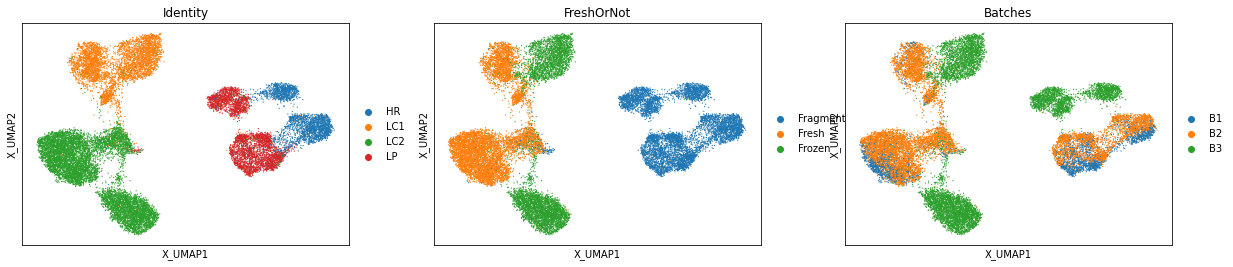

In [10]:
sc.pl.embedding(adata,"X_UMAP",color=["Identity","FreshOrNot","Batches"])

Build adata object with only the AUC_Matrix in for simplicity

In [11]:
aucdat = ad.AnnData(X=auc_mtx,obs=adata.obs)
aucdat.obsm["X_UMAP"] = dr_umap

## Compute RSS (regulon specifity score)
Here we identify regulons that are specific to any of the cell types

In [12]:
from pyscenic.rss import regulon_specificity_scores
from pyscenic.plotting import plot_rss
import matplotlib.pyplot as plt
from adjustText import adjust_text
import seaborn as sns
from pyscenic.binarization import binarize

In [13]:
rss_cellType = regulon_specificity_scores(auc_mtx, aucdat.obs.Identity)
rss_cellType

,AGMAT(+),ALX4(+),ARID3A(+),ARNT(+),ARNT2(+),ARNTL(+),ASCL2(+),ATF1(+),ATF2(+),ATF3(+),...,ZNF787(+),ZNF81(+),ZNF816(+),ZNF878(+),ZNF90(+),ZNF91(+),ZSCAN29(+),ZSWIM1(+),ZXDA(+),ZXDB(+)
HR,0.255668,0.206330,0.330201,0.267080,0.203521,0.313985,0.216493,0.281345,0.367405,0.310530,...,0.295566,0.235532,0.195155,0.295572,0.172056,0.382027,0.326257,0.177496,0.187098,0.172569
LC1,0.184743,0.195522,0.322822,0.394529,0.225152,0.419211,0.436756,0.358386,0.310461,0.415476,...,0.419365,0.406557,0.295486,0.337064,0.180575,0.345174,0.241987,0.192589,0.220557,0.197250
LC2,0.233529,0.292782,0.392432,0.514711,0.214932,0.398798,0.565684,0.455359,0.343123,0.451455,...,0.443024,0.318026,0.235900,0.197703,0.188888,0.431493,0.241183,0.304950,0.206159,0.375169
LP,0.177251,0.195307,0.306016,0.275775,0.425943,0.289151,0.237721,0.378233,0.347458,0.343868,...,0.351513,0.218270,0.382835,0.327340,0.175572,0.361366,0.290128,0.174314,0.242361,0.178345


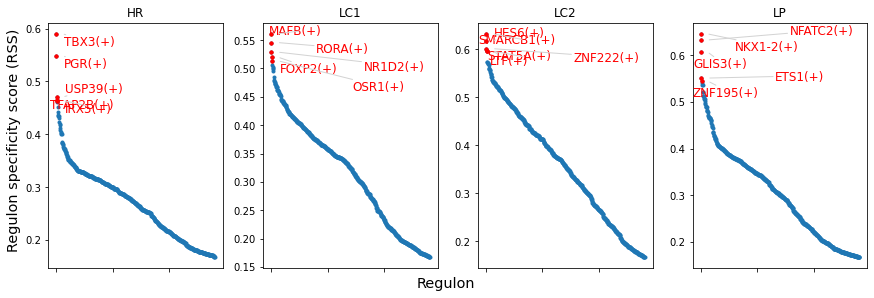

In [14]:
cats = sorted(list(set(aucdat.obs.Identity)))

fig = plt.figure(figsize=(12, 4))
for c,num in zip(cats, range(1,len(cats)+1)):
    x=rss_cellType.T[c]
    ax = fig.add_subplot(1,4,num)
    plot_rss(rss_cellType, c, top_n=5, max_n=None, ax=ax)
    ax.set_ylim( x.min()-(x.max()-x.min())*0.05 , x.max()+(x.max()-x.min())*0.05 )
    for t in ax.texts:
        t.set_fontsize(12)
    ax.set_ylabel('')
    ax.set_xlabel('')
    adjust_text(ax.texts, autoalign='xy', ha='right', va='bottom', arrowprops=dict(arrowstyle='-',color='lightgrey'), precision=0.001 )
 
fig.text(0.5, 0.0, 'Regulon', ha='center', va='center', size='x-large')
fig.text(0.00, 0.5, 'Regulon specificity score (RSS)', ha='center', va='center', rotation='vertical', size='x-large')
plt.tight_layout()
plt.rcParams.update({
    'figure.autolayout': True,
        'figure.titlesize': 'large' ,
        'axes.labelsize': 'medium',
        'axes.titlesize':'large',
        'xtick.labelsize':'medium',
        'ytick.labelsize':'medium'
        })

## We can also plot this as heatmap of the top specific regulons

Select top 10 regulons per cell type

In [15]:
topreg = []
for i,c in enumerate(cats):
    topreg.extend(
        list(rss_cellType.T[c].sort_values(ascending=False)[:10].index)
    )
topreg = list(set(topreg))

Convert to z-scores for plotting

In [16]:
auc_mtx_Z = pd.DataFrame( index=auc_mtx.index )
for col in list(auc_mtx.columns):
    auc_mtx_Z[ col ] = ( auc_mtx[col] - auc_mtx[col].mean()) / auc_mtx[col].std(ddof=0)
#auc_mtx_Z.sort_index(inplace=True)

### Make heatmap

In [17]:
def palplot(pal, names, colors=None, size=1):
    n = len(pal)
    f, ax = plt.subplots(1, 1, figsize=(n * size, size))
    ax.imshow(np.arange(n).reshape(1, n),
              cmap=mpl.colors.ListedColormap(list(pal)),
              interpolation="nearest", aspect="auto")
    ax.set_xticks(np.arange(n) - .5)
    ax.set_yticks([-.5, .5])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    colors = n * ['k'] if colors is None else colors
    for idx, (name, color) in enumerate(zip(names, colors)):
        ax.text(0.0+idx, 0.0, name, color=color, horizontalalignment='center', verticalalignment='center')
    return f

In [18]:
colors = sns.color_palette(["#CD6889","#7A67EE","#DDA0DD","#CD3278"])
colorsd = dict( zip( cats, colors ))
colormap = [ colorsd[x] for x in aucdat.obs.Identity ]

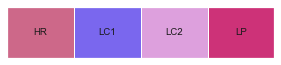

In [19]:
sns.set()
sns.set(font_scale=0.8)
fig = palplot( colors, cats, size=1.0)

/Users/karstenbach/miniconda/envs/scrna/lib/python3.7/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


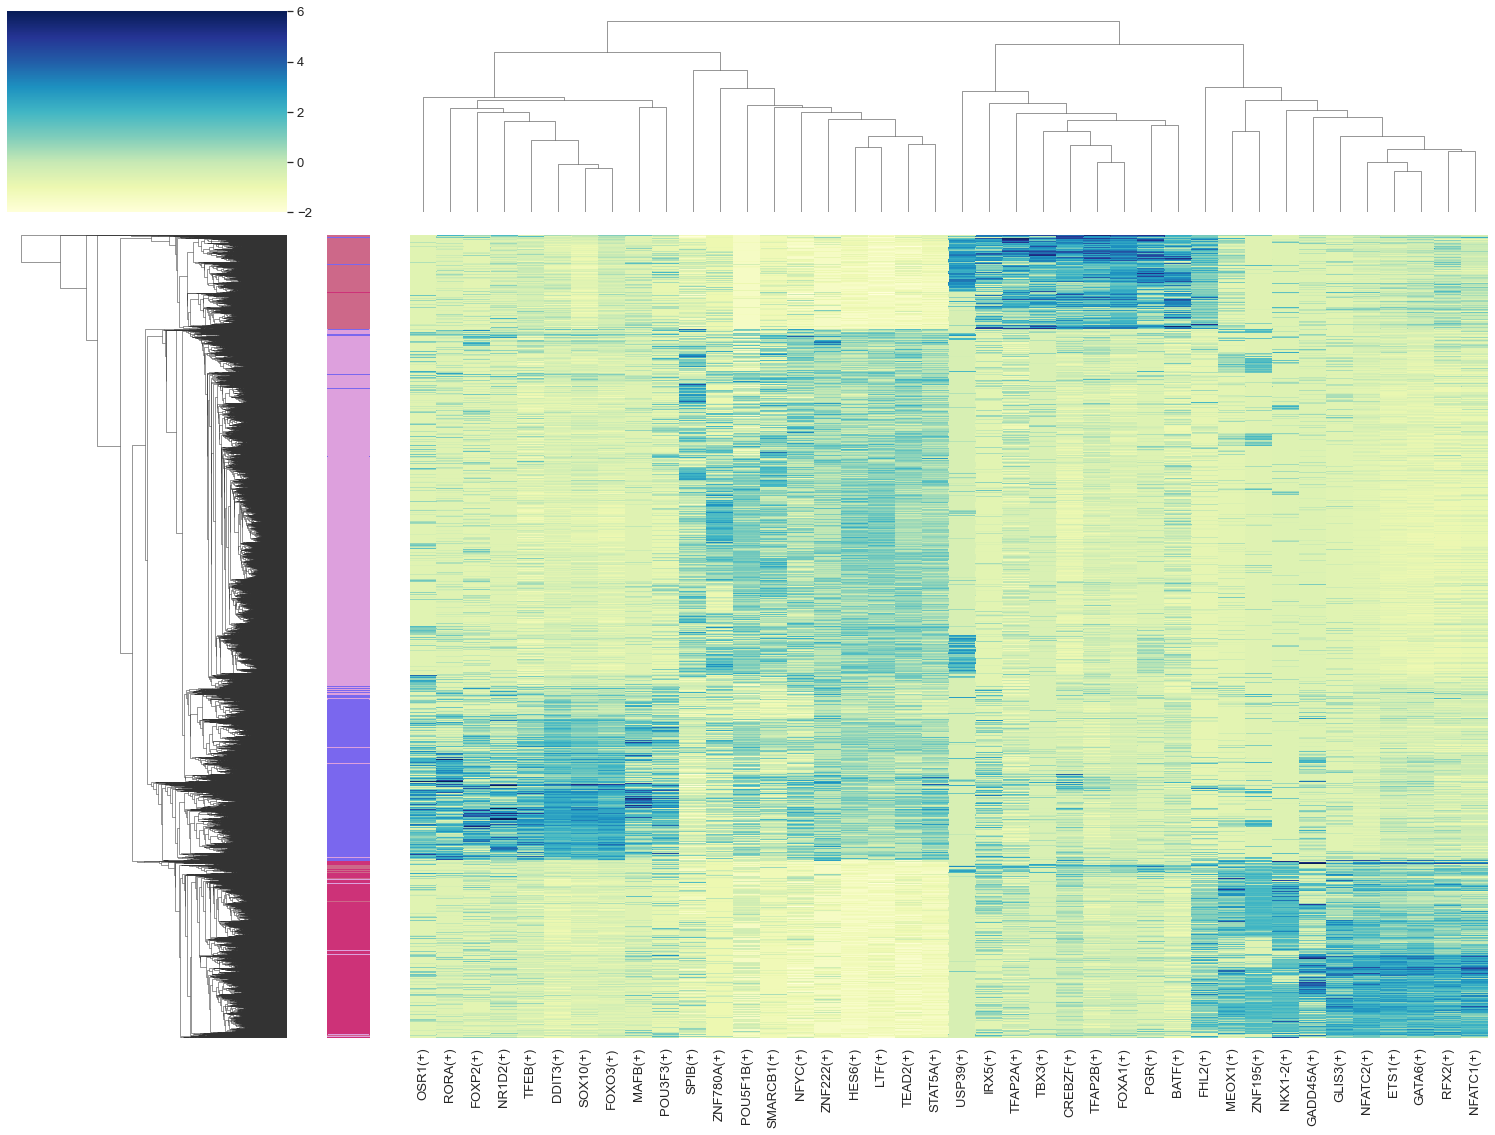

In [20]:
sns.set(font_scale=1.2)
g = sns.clustermap(auc_mtx_Z[topreg], annot=False,  square=False,  linecolor='gray',
    yticklabels=False, xticklabels=True, vmin=-2, vmax=6, row_colors=colormap,
    cmap="YlGnBu", figsize=(21,16) )
g.cax.set_visible(True)
g.ax_heatmap.set_ylabel('')
g.ax_heatmap.set_xlabel('')
g.savefig("Heatmap.png")

### We can also plot some of these as UMAPs if we fancy

/Users/karstenbach/miniconda/envs/scrna/lib/python3.7/site-packages/IPython/core/pylabtools.py:134: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


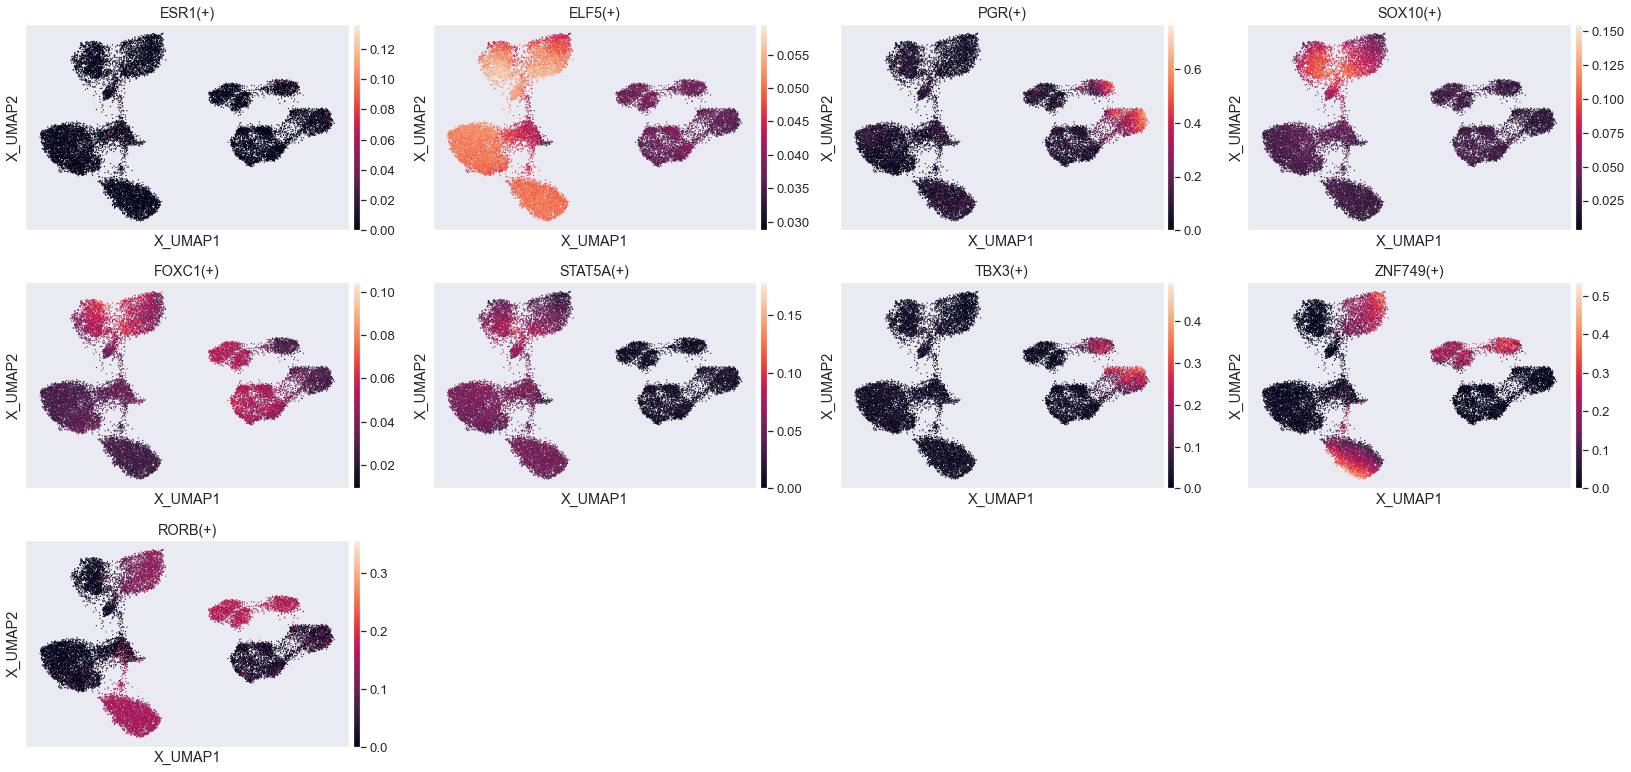

In [21]:
regs = ["ESR1(+)","ELF5(+)","PGR(+)","SOX10(+)","FOXC1(+)","STAT5A(+)","TBX3(+)","ZNF749(+)","RORB(+)"]
sc.pl.embedding(aucdat,"X_UMAP",color=regs)

# Look at regulons
Here I export some of the regulons as txt files to investigate them more closely.

In [22]:
adjacencies = pd.read_csv("../data/SCENIC_adj_subset1k.csv", index_col=False, sep=',')
from pyscenic.utils import modules_from_adjacencies
modules = list(modules_from_adjacencies(adjacencies, exprMat))


2021-07-30 10:49:29,530 - pyscenic.utils - INFO - Calculating Pearson correlations.

2021-07-30 10:49:31,056 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2021-07-30 12:06:27,116 - pyscenic.utils - INFO - Creating modules.


In [23]:
tf = 'SOX10'
tf_mods = [ x for x in modules if x.transcription_factor==tf ]

for i,mod in enumerate( tf_mods ):
    print( f'{tf} module {str(i)}: {len(mod.genes)} genes' )
print( f'{tf} regulon: {len(regulons[tf+"(+)"])} genes' )

SOX10 module 0: 3937 genes
SOX10 module 1: 2199 genes
SOX10 module 2: 51 genes
SOX10 module 3: 295 genes
SOX10 module 4: 597 genes
SOX10 module 5: 2119 genes
SOX10 regulon: 345 genes


In [24]:
for i,mod in enumerate( tf_mods ):
    with open( tf+'_module_'+str(i)+'.txt', 'w') as f:
        for item in mod.genes:
            f.write("%s\n" % item)
            
with open( tf+'_regulon.txt', 'w') as f:
    for item in regulons[tf+'(+)']:
        f.write("%s\n" % item)

In [25]:
for tf in topreg:            
    with open( tf+'_regulon.txt', 'w') as f:
        for item in regulons[tf]:
            f.write("%s\n" % item)